## RETRIEVING LIPAS SPORTS FACILITIES

This code gets the point features fron LIPAS database and keeps the ones inside the Helsinki Metropolitan Area.

In [1]:
# importing modules
import geopandas as gpd
import pandas as pd
import pyproj
import os.path 
import requests
import geojson
import shapely
import matplotlib.pyplot as plt
from pyproj import CRS
import contextily as ctx

In [2]:
# Fetch data from WFS using requests
r = requests.get('http://geo.stat.fi/geoserver/tilastointialueet/wfs', params=dict(service='WFS', version='2.0.0', request='GetFeature', typeName='tilastointialueet:kunta1000k', outputFormat='json'))

#get a shapefile of municipalities
municip = gpd.GeoDataFrame.from_features(geojson.loads(r.content),  crs="EPSG:3067")

jyvaskyla = municip.loc[municip["nimi"] == "Jyväskylä"]

In [3]:
jyvaskyla.total_bounds

array([ 409056.613, 6857100.673,  450731.448, 6922750.799])

In [4]:
#retrieve data as wfs
r = requests.get("""http://lipas.cc.jyu.fi/geoserver/lipas/ows?service=wfs&version=2.0.0&request=GetFeature&typeNames=lipas:lipas_kaikki_pisteet&bbox=409056.613,6857100.673,450731.448,6922750.799,EPSG:3067&outputFormat=json""")
lipas_pisteet = gpd.GeoDataFrame.from_features(geojson.loads(r.content))
lipas_pisteet.crs = "epsg:3067"

#retrieve the sports facilities in Helsinki Metropolitan area
lipas_data = gpd.overlay(lipas_pisteet, jyvaskyla, how="intersection")


# Removing unnecessary attributes from lipas_data
lipas_data = lipas_data[["geometry","id","nimi_fi","tyyppi_nimi_fi"]]
    
lipas_data = lipas_data.reset_index()

for i in range(len(lipas_data)):

    lipas_data.loc[i, "nimi"] = lipas_data["nimi_fi"][i].split("/")[0]


lipas_data = lipas_data[["nimi_fi", "tyyppi_nimi_fi", "geometry", "nimi"]]

lipas_data

,nimi_fi,tyyppi_nimi_fi,geometry,nimi
0,Kirrinpuiston pallokenttä,Pallokenttä,POINT (433003.617 6908304.553),Kirrinpuiston pallokenttä
1,Lohikosken pallokenttä,Pallokenttä,POINT (435539.215 6904418.507),Lohikosken pallokenttä
2,Viitaniemen tekojääkenttä,Tekojääkenttä,POINT (434207.820 6902538.776),Viitaniemen tekojääkenttä
3,Leiviskän tilan maneesi,Ratsastusmaneesi,POINT (431548.457 6916584.293),Leiviskän tilan maneesi
4,Väinölän pallokenttä,Pallokenttä,POINT (438662.883 6900737.720),Väinölän pallokenttä
...,...,...,...,...
552,Vuorilammen laavu,"Laavu, kota tai kammi",POINT (438278.500 6903907.375),Vuorilammen laavu
553,Palokan kuntokeskus,Kuntosali,POINT (434668.204 6906878.669),Palokan kuntokeskus
554,Fitness24Seven Jyväskylä Palokka,Kuntokeskus,POINT (433405.996 6906716.367),Fitness24Seven Jyväskylä Palokka
555,Luonetjärven pistoolirata,Ampumarata,POINT (429645.750 6919815.250),Luonetjärven pistoolirata


<AxesSubplot:>

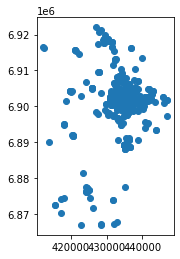

In [5]:
lipas_data.plot()

In [6]:
lipas_data.to_file("lipas_jyvaskyla.gpkg", driver='GPKG')

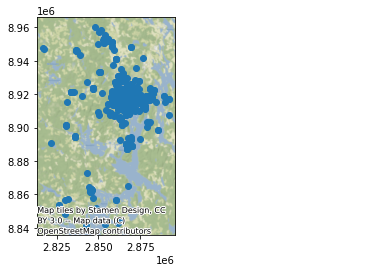

In [7]:
lipas_ctx = lipas_data.to_crs(epsg=3857)
ax = lipas_ctx.plot()
ctx.add_basemap(ax)